# Studying phase angle differences in tips that annihilate
Tim Tyree<br>
5.11.2021

In [2]:
from lib.routines.return_reaction_ranges_from_folder import *
from lib.my_initialization import *
from lib import *
from lib.utils.merge_cloud_results import *
import seaborn as sns
# from scipy.interpolate import CubicSpline
from scipy.interpolate import splprep, splev
import matplotlib
%load_ext autoreload
%autoreload 2
# TODO: find when birth occurs for the tip of interest (HINT: look at the video!!!)
# TODO: make a video where activation fronts are highlighted by curvature!


# TODO: do tips that annihilate synch up in phase just before death? 
- TODO: measure the initial velocities of spiral tips at birth
are they significantly directed away from one another?

In [214]:
def compute_phase_angles_from_grad_voltage(d1,d2):
    #compute the displacement vector between these spiral tips
    d1['x2']=d2['x']
    d1['y2']=d2['y']
    d1['dx']=d1['x2']-d1['x']
    d1['dy']=d1['y2']-d1['y']
    d1['range']=np.sqrt(d1['dx']**2+d1['dy']**2)
    d1['dxhat']=d1['dx']/d1['range']
    d1['dyhat']=d1['dy']/d1['range']
    d2['dxhat']=d1['dxhat']
    d2['dyhat']=d1['dyhat']
    d1['grad_u_mag']=np.sqrt(d1['grad_ux']**2+d1['grad_uy']**2)
    d2['grad_u_mag']=np.sqrt(d2['grad_ux']**2+d2['grad_uy']**2)
    
#     #cosine method is equivalent up to sign
#     # - using cross product of dx,y_hat with +-ahat
#     #TODO: - using  dot  product of dx,y_hat with +,-grad_u
#     #compute the min/max absolute phase angles 
#     cosine_values=(d1['dxhat']*d1['grad_ux']+d1['dyhat']*d1['grad_uy'])/d1['grad_u_mag']
#     d1['phi1']=np.arcsin(cosine_values)
#     cosine_values=(d2['dxhat']*d2['grad_ux']+d2['dyhat']*d2['grad_uy'])/d2['grad_u_mag']
#     d2['phi2']=np.arcsin(cosine_values)
#     boo=~d1.phi1.isnull()
#     t1_values=d1[boo]['t'].values
#     boo=~d2.phi2.isnull()
#     t2_values=d2[boo]['t'].values

    d1['a1x']=d1['grad_uy']/d1['grad_u_mag']
    d1['a1y']=-d1['grad_ux']/d1['grad_u_mag']
    sine_values_left=d1['a1x']*d1['dyhat']-d1['a1y']*d1['dxhat']
    sine_values_right=-d1['a1x']*d1['dyhat']+d1['a1y']*d1['dxhat']

    if np.arcsin(sine_values_left).values[-1]>0:
        # choose self-consistent convention that ends in giving phi a positive phase value
        d1['phi1']=np.arcsin(sine_values_left)
    else:
        d1['phi1']=np.arcsin(sine_values_right)

    d2['ax']=d2['grad_uy']/d2['grad_u_mag']
    d2['ay']=-d2['grad_ux']/d2['grad_u_mag']
    sine_values_left=d2['ax']*d2['dyhat']-d2['ay']*d2['dxhat']
    sine_values_right=-d2['ax']*d2['dyhat']+d2['ay']*d2['dxhat']

    if np.arcsin(sine_values_left).values[-1]<0:
        # choose self-consistent convention that ends in giving phi a negative phase value
        d2['phi2']=np.arcsin(sine_values_left)
    else:
        d2['phi2']=np.arcsin(sine_values_right)

    boo=~d1.phi1.isnull()
    t1_values=d1[boo]['t'].values
    x_values=t1_values[-1]-t1_values
    phi1_values=d1[boo]['phi1'].values

    boo=~d2.phi2.isnull()
    t2_values=d2[boo]['t'].values
    phi2_values=d2[boo]['phi2'].values

    phi_sum_values=phi1_values+phi2_values
    phi_diff_values=phi1_values-phi2_values
    t_to_death_values=x_values
    return t_to_death_values, phi1_values, phi2_values, phi_sum_values, phi_diff_values

In [215]:
#Token fk model
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-300x300/ds_7.5_param_set_8/Log/ic300x300.0.6_traj_sr_600_mem_0.csv"
#Token lr model
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-lr-300x300/param_qu_tmax_30/trajectories/ic300x300.3.3_traj_sr_600_mem_0.csv"
DS=5/200

# input_fn=search_for_file()
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.3_traj_sr_400_mem_0.csv"
df=pd.read_csv(input_fn)
DT=compute_DT(df,round_t_to_n_digits=3);print(DT)

0.4


In [216]:
# death_ranges,birth_ranges,DT=return_bd_ranges(input_fn,DS,round_t_to_n_digits=3)
#compute interactions
df_interactions=compute_df_interactions(input_fn,DS=DS)
df_interactions.dropna(inplace=True)
death_ranges=DS*df_interactions.rT.values
birth_ranges=DS*df_interactions.r0.values

In [191]:
# from inspect import getsource
# print(getsource(compute_df_interactions))

In [217]:
#filter any deaths that occur at ranges exceeding 1 cm
range_threshold=1.#cm
boo=df_interactions.rT*DS<range_threshold
df_ordered_interactions=df_interactions[boo].sort_values('Tavg',ascending=False)

In [218]:
#for the first pid and its mate,
pid,pid_deathmate=df_ordered_interactions.head(1)[['pid','pid_deathmate']].values[0]
#extract their trajectories/particle dataframes
d1=df[df.particle==pid].copy()
d2=df[df.particle==pid_deathmate].copy()
d1.index=d1.frame
d2.index=d2.frame
#compute the phase time series between pid and pid_deathmate

#find last zero for when phi1==0

#compute phi2 at that time using linear interpolation

#append phi2 to dphi_lst... proceed to the next particle

In [194]:
#TODO: compute a1 using grad_ux and grad_uy


$$
\text{Let   } \phi_1\equiv\cos^{-1}\big(\widehat{\mathbf{x}_2-\mathbf{x}_1}\;\cdot\;\hat{\mathbf{a}}_1\big),
$$

$$
\text{and let   } \phi_2\equiv\cos^{-1}\big(\widehat{\mathbf{x}_1-\mathbf{x}_2}\;\cdot\;\hat{\mathbf{a}}_2\big).
$$

denote the (unsigned) phases of particle 1 & 2, where $\mathbf{a}_1$ and $\mathbf{a}_2$ are perpendicular to $\nabla V\equiv$ (grad_ux,grad_uy).

In [195]:
# grad_ux1_values=d1.grad_ux.values
# grad_uy1_values=d1.grad_uy.values
# x1_values=d1.x.values
# y1_values=d1.y.values

# a1_left_values=
# a1_right_values=

In [196]:
# xy1_values=np.array(list(zip(d1['x'],d1['y'])))
# xy2_values=np.array(list(zip(d2['x'],d2['y'])))
# xy2_minus_xy1_values=xy2_values-xy1_values
# range_values=np.linalg.norm(xy2_minus_xy1_values, axis=1)
# x2_minus_x1_hat_values=xy2_minus_xy1_values[:,0]/range_values
# y2_minus_y1_hat_values=xy2_minus_xy1_values[:,1]/range_values
# xy2_minus_xy1_hat_values=np.array(list(zip(x2_minus_x1_hat_values,y2_minus_y1_hat_values)))


In [219]:
t_to_death_values, phi1_values, phi2_values, phi_sum_values, phi_diff_values=compute_phase_angles_from_grad_voltage(d1,d2)
x_values=t_to_death_values

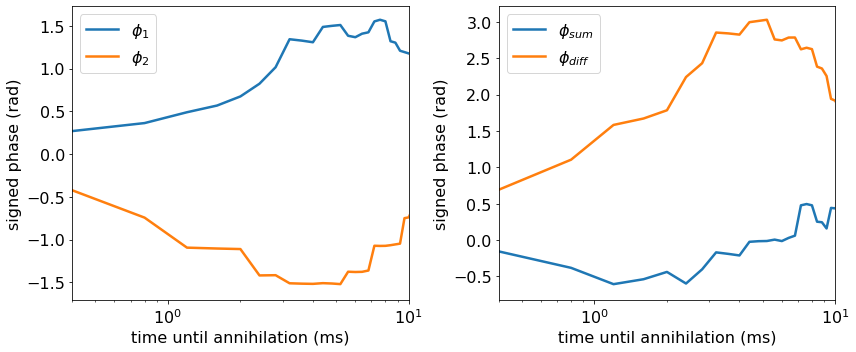

In [220]:
fontsize=16
#plot naive range at death and birth
fig,axs=plt.subplots(ncols=2,figsize=(12,5))#(5,4))

y_values_lst=[phi1_values,phi2_values,phi_sum_values, phi_diff_values]
y_label_lst=[r'$\phi_1$',r'$\phi_2$',r'$\phi_{sum}$',r'$\phi_{diff}$']
ax_lst=[0,0,1,1]
c_lst=['C0','C1','C0','C1']

for y_values,y_label,nax,color in zip(y_values_lst,y_label_lst,ax_lst,c_lst):
    ax=axs[nax]
    ax.plot(x_values,y_values,alpha=1.0,label=y_label,c=color,lw=2.5)
    # plt.scatter(x_values[boo],range_values[boo],c='k',alpha=0.5,s=3)
    ax.set_xlabel('time until annihilation (ms)',fontsize=fontsize)
    ax.set_ylabel('signed phase (rad)',fontsize=fontsize)

    ax.set_xlim([DT,1e1])
#     ax.set_ylim([-np.pi/8,np.pi/8])
    #     ax.set_xlim([1e-3,1e2])
    ax.set_xscale('log')
    # plt.yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=1)
    ax.legend(fontsize=fontsize)

plt.tight_layout()
# plt.show()
# print(f"\ttime between two frames was {0.001} ms")

saving=False
savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=f"fine-death-range-phase.png"
plt.tight_layout()
if not saving: 
    plt.show() 
else:
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

# compute mean phase angle difference near death

In [183]:
#TODO: compute crossing of zero
#TODO: does phi_sum always cross zero here?

In [221]:
#TODO: plot all trajectories in the pid_lst
pid_queue=list(df_ordered_interactions.pid.values)
pid_deathmate_dict=dict(zip(pid_queue,list(df_ordered_interactions.pid_deathmate.values)))
df_out_lst=[]
while len(pid_queue)>0:
    pid=pid_queue.pop(0)
    pid_deathmate=pid_deathmate_dict[pid]
    try:
        pid_queue.remove(pid_deathmate)
        #extract d1,d2
        d1=df[df.particle==pid].copy()
        d2=df[df.particle==pid_deathmate].copy()
        d1.index=d1.frame
        d2.index=d2.frame
        #compute x,y values
        t_to_death_values, phi1_values, phi2_values, phi_sum_values, phi_diff_values=compute_phase_angles_from_grad_voltage(d1,d2)
        x_values=t_to_death_values
        df_out=pd.DataFrame({
            'tdeath':t_to_death_values,
            'phi1':np.abs(phi1_values),
            'phi2':np.abs(phi2_values),
            'phi_sum':np.abs(phi_sum_values),
            'phi_diff':np.abs(phi_diff_values),
            'pid':pid
        })
        #append x,y values to list
        df_out_lst.append(df_out)
    except ValueError as e:
        pass

In [222]:
df_phases=pd.concat(df_out_lst)
# df_phases.head()

In [223]:
#TODO: plot xy values for pid in list
#TODO: compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tdeath').mean()
x_values=dfm.index.values
y_values=dfm.phi_diff.values
# plt.plot(x_values,y_values)

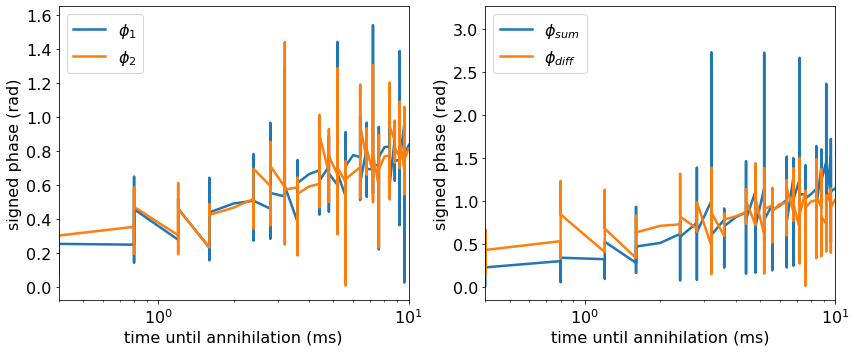

In [224]:
fontsize=16
#plot naive range at death and birth
fig,axs=plt.subplots(ncols=2,figsize=(12,5))#(5,4))

y_values_lst=[dfm.phi1.values,dfm.phi2.values,dfm.phi_sum.values, dfm.phi_diff.values]
# y_values_lst=[phi1_values,phi2_values,phi_sum_values, phi_diff_values]
y_label_lst=[r'$\phi_1$',r'$\phi_2$',r'$\phi_{sum}$',r'$\phi_{diff}$']
ax_lst=[0,0,1,1]
c_lst=['C0','C1','C0','C1']

for y_values,y_label,nax,color in zip(y_values_lst,y_label_lst,ax_lst,c_lst):
    ax=axs[nax]
    ax.plot(x_values,y_values,alpha=1.0,label=y_label,c=color,lw=2.5)
    # plt.scatter(x_values[boo],range_values[boo],c='k',alpha=0.5,s=3)
    ax.set_xlabel('time until annihilation (ms)',fontsize=fontsize)
    ax.set_ylabel('signed phase (rad)',fontsize=fontsize)

    ax.set_xlim([DT,1e1])
#     ax.set_ylim([-np.pi/8,np.pi/8])
    #     ax.set_xlim([1e-3,1e2])
    ax.set_xscale('log')
    # plt.yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=1)
    ax.legend(fontsize=fontsize)

plt.tight_layout()
# plt.show()
# print(f"\ttime between two frames was {0.001} ms")

saving=False
savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=f"fine-death-range-phase.png"
plt.tight_layout()
if not saving: 
    plt.show() 
else:
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

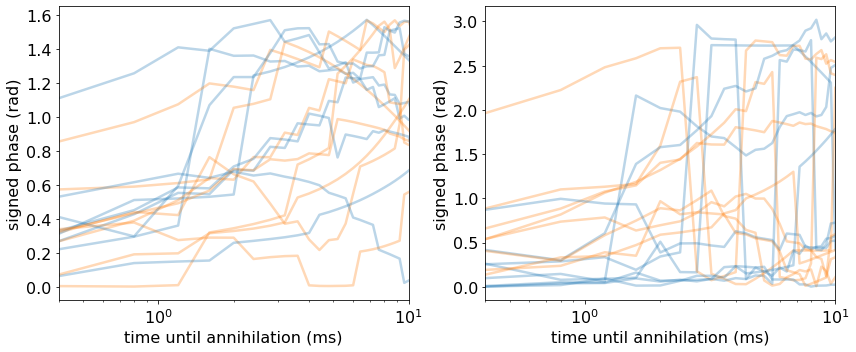

In [225]:
fontsize=16
#plot naive range at death and birth
fig,axs=plt.subplots(ncols=2,figsize=(12,5))#(5,4))

# y_values_lst=[dfm.phi1.values,dfm.phi2.values,dfm.phi_sum.values, dfm.phi_diff.values]
# y_values_lst=[phi1_values,phi2_values,phi_sum_values, phi_diff_values]
y_label_lst=[r'$\phi_1$',r'$\phi_2$',r'$\phi_{sum}$',r'$\phi_{diff}$']
ax_lst=[0,0,1,1]
c_lst=['C0','C1','C0','C1']

#extract local particle values
pid_lst=list(set(df_phases.pid.values))
for pid in pid_lst[:10]:
# pid=pid_lst[0]
    boo=df_phases.pid==pid
    y_values_lst=[df_phases[boo].phi1.values,df_phases[boo].phi2.values,df_phases[boo].phi_sum.values, df_phases[boo].phi_diff.values]
    x_values=df_phases[boo].tdeath.values
    for y_values,y_label,nax,color in zip(y_values_lst,y_label_lst,ax_lst,c_lst):
        ax=axs[nax]
        ax.plot(x_values,y_values,alpha=.3,label='_Hidden',c=color,lw=2.5)
        # plt.scatter(x_values[boo],range_values[boo],c='k',alpha=0.5,s=3)
        ax.set_xlabel('time until annihilation (ms)',fontsize=fontsize)
        ax.set_ylabel('signed phase (rad)',fontsize=fontsize)

        ax.set_xlim([DT,1e1])
    #     ax.set_ylim([-np.pi/8,np.pi/8])
        #     ax.set_xlim([1e-3,1e2])
        ax.set_xscale('log')
        # plt.yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=1)
    #     ax.legend(fontsize=fontsize)

plt.tight_layout()
# plt.show()
# print(f"\ttime between two frames was {0.001} ms")

saving=False
savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=f"fine-death-range-phase.png"
plt.tight_layout()
if not saving: 
    plt.show() 
else:
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

## TODO(later): take more data for DT=0.01 or DT=0.001 ms.
- HINT: use the 2 step method for accurately determining the position of valid spiral tips
- HINT: use the active contour method to avoid the sign issue at the expense of run time
- HINT: only do ~100 cpu's for ~20 hours for the LR model
## TODO(later): replot phases... values should line up better